In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%run functions.py

### Importação dos Dados

In [43]:
images = pd.read_csv("imageMNIST.csv", header=None, decimal=',')
labels = np.array(pd.read_csv("labelMNIST.csv", header=None))
X, zero_cols = zero_col(images)
y = np.asarray(labels)

In [63]:
input_layer_size = X.shape[1]
hidden_layer_size = np.array([25, 25])#Array com as camadas escondidas e suas respectivas quantidades de neurônios
num_labels = 10
n_layers = hidden_layer_size.shape[0]
Lambda = 0.01

theta = []

theta.append(randInitializeWeights(input_layer_size,hidden_layer_size[0]))
if(n_layers > 1):
    for i in range(hidden_layer_size.shape[0]-1):
        theta.append(randInitializeWeights(hidden_layer_size[i],hidden_layer_size[i+1]))
        
theta.append(randInitializeWeights(hidden_layer_size[-1],num_labels))


theta,J_history = gradientDescent(X,y,theta,0.8,100, Lambda,input_layer_size,hidden_layer_size,num_labels)

In [64]:
pred = prediction(X,theta)
print("Training Set Accuracy:",np.sum(pred == y)/50,"%")

Training Set Accuracy: 22.68 %


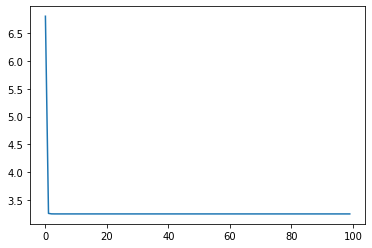

In [65]:
plt.plot(J_history)